# Statistical Natural Language Processing (WS 20/21)
## Exercise Sheet 3 - Manuel Hettich

In [1]:
'''
This function can be used for importing the corpus.
Parameters: path_to_file: string; path to the file containing the corpus
Returns: list of list; the first layer list contains the sentences of the corpus;
    the second layer list contains tuples (token,label) representing a labelled sentence
'''
def import_corpus(path_to_file):
    sentences = []
    sentence = []
    f = open(path_to_file)

    while True:
        line = f.readline()
        if not line: break

        line = line.strip()
        if len(line) == 0:
            sentences.append(sentence)
            sentence = []
            continue

        parts = line.split(' ')
        sentence.append((parts[0], parts[-1]))

    f.close()
    return sentences

In [2]:
# Imports
import itertools
import random
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class MaxEntModel(object):
    # training corpus
    corpus = None

    # (numpy) array containing the parameters of the model
    # has to be initialized by the method 'initialize'
    theta = None

    # dictionary containing all possible features of a corpus and their corresponding index;
    # has to be set by the method 'initialize'; hint: use a Python dictionary
    feature_indices = None

    # set containing a list of possible labels
    # has to be set by the method 'initialize'
    labels = None

    # Caching normalization factors for (word, label)
    norm_factors = None


    # Exercise 1 a) ###################################################################
    def initialize(self, corpus):
        """
        Initialize the maximum entropy model, i.e., build the set of all features, the set of all labels
        and create an initial array 'theta' for the parameters of the model.
        Parameters: corpus: list of list representing the corpus, returned by the function 'import_corpus'
        """
        self.corpus = corpus

        # Initialise the set of all words in the corpus
        words = set()
        # Add a custom label for the beginning of sentences
        self.labels = set()
        self.labels.add("start")

        # Fill the two sets with all the words and labels in the corpus
        for sentence in corpus:
            for word, label in sentence:
                words.add(word)
                self.labels.add(label)

        # Initialise the feature indices dictionary
        self.feature_indices = dict()
        # Build the necessary cartesian products and store them enumerated in the dict
        product = set()
        product.update(itertools.product(self.labels, self.labels))
        product.update(itertools.product(words, self.labels))
        for idx, feature in enumerate(product):
            self.feature_indices.update({feature: idx})

        # Initialize theta
        self.theta = np.ones(len(self.feature_indices))

        # Initialize norm_factors
        self.norm_factors = dict()

    # Exercise 1 b) ###################################################################
    def get_active_features(self, word, label, prev_label):
        """
        Compute the vector of active features.
        Parameters: word: string; a word at some position i of a given sentence
                    label: string; a label assigned to the given word
                    prev_label: string; the label of the word at position i-1
        Returns: (numpy) array containing only zeros and ones.
        """

        # Get the indices for the two features
        idx_word_label = self.feature_indices.get((word, label), -1)
        idx_label_label = self.feature_indices.get((prev_label, label), -1)

        # Create a numpy array with the two features set to 1
        # according to the indices in self.feature_indices
        active_features = np.zeros(len(self.feature_indices), dtype=bool)
        if idx_word_label != -1:
            active_features[idx_word_label] = True
        if idx_label_label != -1:
            active_features[idx_label_label] = True

        return active_features

    # Exercise 2 a) ###################################################################
    def cond_normalization_factor(self, word, prev_label):
        """
        Compute the normalization factor 1/Z(x_i).
        Parameters: word: string; a word x_i at some position i of a given sentence
                    prev_label: string; the label of the word at position i-1
        Returns: float
        """

        if (word, prev_label) in self.norm_factors:
            return self.norm_factors[(word, prev_label)]
        else:
            z = 0.0
            for label in self.labels:
                z += np.exp(np.dot(self.theta, self.get_active_features(word, label, prev_label)))

            norm_factor = 1 / z
            # Cache the normalization factor
            self.norm_factors[(word, prev_label)] = norm_factor

            return norm_factor


    # Exercise 2 b) ###################################################################
    def conditional_probability(self, label, word, prev_label):
        """
        Compute the conditional probability of a label given a word x_i.
        Parameters: label: string; we are interested in the conditional probability of this label
                    word: string; a word x_i some position i of a given sentence
                    prev_label: string; the label of the word at position i-1
        Returns: float
        """

        normalization_factor = self.cond_normalization_factor(word, prev_label)

        return normalization_factor * np.exp(np.dot(self.theta, self.get_active_features(word, label, prev_label)))


    # Exercise 3 a) ###################################################################
    def empirical_feature_count(self, word, label, prev_label):
        """
        Compute the empirical feature count given a word, the actual label of this word and the label of the previous word.
        Parameters: word: string; a word x_i some position i of a given sentence
                    label: string; the actual label of the given word
                    prev_label: string; the label of the word at position i-1
        Returns: (numpy) array containing the empirical feature count
        """

        return self.get_active_features(word, label, prev_label)


    # Exercise 3 b) ###################################################################
    def expected_feature_count(self, word, prev_label):
        """
        Compute the expected feature count given a word, the label of the previous word and the parameters of the current model
        (see variable theta)
        Parameters: word: string; a word x_i some position i of a given sentence
                    prev_label: string; the label of the word at position i-1
        Returns: (numpy) array containing the expected feature count
        """

        expected_feature_count = np.zeros(len(self.theta))

        for label in self.labels:
            expected_feature_count += self.get_active_features(word, label, prev_label) * self.conditional_probability(label, word, prev_label)

        return expected_feature_count


    # Exercise 4 a) ###################################################################
    def parameter_update(self, word, label, prev_label, learning_rate):
        """
        Do one learning step.
        Parameters: word: string; a randomly selected word x_i at some position i of a given sentence
                    label: string; the actual label of the selected word
                    prev_label: string; the label of the word at position i-1
                    learning_rate: float
        """

        self.theta += learning_rate * (self.empirical_feature_count(word, label, prev_label) - self.expected_feature_count(word, prev_label))

        # Reset the cached normalization factors
        self.norm_factors = dict()


    # Exercise 4 b) ###################################################################
    def train(self, number_iterations, learning_rate=0.1):
        """
        Implement the training procedure.
        Parameters: number_iterations: int; number of parameter updates to do
                    learning_rate: float
        """

        for iteration in range(number_iterations):
            print(f"Iteration {iteration + 1}/{number_iterations}")

            # Select a random sentence from the corpus
            random_sentence = random.choice(self.corpus)
            # Select a random tuple from the random sentence
            random_tuple = random.choice(random_sentence)
            word = random_tuple[0]
            label = random_tuple[1]

            # Get the label of the previous tuple in the random sentence
            idx_random_tuple = random_sentence.index(random_tuple)
            if idx_random_tuple == 0:
                prev_label = "start"
            else:
                prev_label = random_sentence[idx_random_tuple - 1][1]

            self.parameter_update(word, label, prev_label, learning_rate)


    # Exercise 4 c) ###################################################################
    def predict(self, word, prev_label):
        """
        Predict the most probable label of the word referenced by 'word'
        Parameters: word: string; a word x_i at some position i of a given sentence
                    prev_label: string; the label of the word at position i-1
        Returns: string; most probable label
        """

        maximum_probability = -np.inf
        result_label = None

        # Find the label with the maximum probability
        for label in self.labels:
            probability = self.conditional_probability(label, word, prev_label)

            if probability > maximum_probability:
                maximum_probability = probability
                result_label = label

        return result_label


    # Exercise 5 a) ###################################################################
    def empirical_feature_count_batch(self, sentences):
        """
        Predict the empirical feature count for a set of sentences
        Parameters: sentences: list; a list of sentences; should be a sublist of the list returned by 'import_corpus'
        Returns: (numpy) array containing the empirical feature count
        """

        # Initialize the empirical feature count array
        empirical_feature_count_batch = np.zeros(len(self.theta), dtype=bool)

        for sentence in sentences:
            first_word = sentence[0][0]
            first_label = sentence[0][1]
            empirical_feature_count_batch += self.empirical_feature_count(first_word, first_label, "start")
            for idx, (word, label) in enumerate(sentence[1:]):
                prev_label = sentence[idx - 1][1]
                empirical_feature_count_batch += self.empirical_feature_count(word, label, prev_label)

        return empirical_feature_count_batch


    # Exercise 5 a) ###################################################################
    def expected_feature_count_batch(self, sentences):
        """
        Predict the expected feature count for a set of sentences
        Parameters: sentences: list; a list of sentences; should be a sublist of the list returned by 'import_corpus'
        Returns: (numpy) array containing the expected feature count
        """

        # Initialize the expected feature count array
        expected_feature_count_batch = np.zeros(len(self.theta))

        for sentence in sentences:
            first_word = sentence[0][0]
            first_label = sentence[0][1]
            expected_feature_count_batch += self.expected_feature_count(first_word, first_label)
            for idx, (word, label) in enumerate(sentence[1:]):
                prev_label = sentence[idx - 1][1]
                expected_feature_count_batch += self.expected_feature_count(word, prev_label)

        return expected_feature_count_batch


    # Exercise 5 b) ###################################################################
    def train_batch(self, number_iterations, batch_size, learning_rate=0.1):
        """
        Implement the training procedure which uses 'batch_size' sentences from to training corpus
        to compute the gradient.
        Parameters: number_iterations: int; number of parameter updates to do
                    batch_size: int; number of sentences to use in each iteration
                    learning_rate: float
        Returns: last batch of sentences
        """

        sentences = None

        for iteration in range(number_iterations):
            print(f"Iteration {iteration + 1}/{number_iterations}")

            # Choose multiple random sentences from the corpus
            sentences = random.choices(self.corpus, k=batch_size)

            self.theta += learning_rate * (self.empirical_feature_count_batch(sentences) - self.expected_feature_count_batch(sentences))

            # Reset the cached normalization factors
            self.norm_factors = dict()

        return sentences

In [14]:
# Exercise 5 c) ###################################################################
def evaluate(corpus):
    """
    Compare the training methods 'train' and 'train_batch' in terms of convergence rate
    Parameters: corpus: list of list; a corpus returned by 'import_corpus'
    """

    def calculate_accuracy(model, num_words):
        # https://en.wikipedia.org/wiki/Accuracy_and_precision#In_binary_classification
        # Accuracy = (TP + TN)/(TP + TN + FP + FN)

        correct_predictions = 0

        for _ in range(num_words):
            random_sentence = random.choice(test_set)
            random_tuple = random.choice(random_sentence)
            idx_random_tuple = random_sentence.index(random_tuple)
            word = random_tuple[0]
            label = random_tuple[1]
            if idx_random_tuple == 0:
                prev_label = "start"
            else:
                prev_label = random_sentence[idx_random_tuple - 1][1]
            pred_label = model.predict(word, prev_label)
            if pred_label == label:
                correct_predictions += 1

        return correct_predictions / num_words

    random.shuffle(corpus)

    # Use 10% of the corpus as test set and the remaining data as training set
    test_set = corpus[0:int(len(corpus) / 10)]
    training_set = corpus[int(len(corpus) / 10):]

    # Initialize two instances of MaxEntModel
    model_a = MaxEntModel()
    model_a.initialize(training_set)
    model_b = MaxEntModel()
    model_b.initialize(training_set)

    # Initialize the word counters
    w_a = 0
    w_b = 0

    # Initialize the accuracies
    accuracy_a = dict()
    accuracy_b = dict()

    # Initialize the learning rates
    learning_rate_a = 0.1
    learning_rate_b = 0.1

    num_iterations = 25
    for iteration in range(num_iterations):
        print(f"Evaluation iteration: {iteration + 1}/{num_iterations}")
        # Train model A on a single random word using train()
        model_a.train(number_iterations=1, learning_rate=learning_rate_a)
        w_a += 1
        accuracy_a.update({w_a: calculate_accuracy(model_a, w_a)})

        # Train model B on a single random sentence using train_batch()
        sentences = model_b.train_batch(number_iterations=1, batch_size=1, learning_rate=learning_rate_b)
        w_b += len(sentences[0])
        accuracy_b.update({w_b: calculate_accuracy(model_b, w_b)})

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.plot(accuracy_a.keys(), accuracy_a.values(), color='blue', label="Model A (train)")
    plt.plot(accuracy_b.keys(), accuracy_b.values(), color='red', label="Model B (train_batch)")
    ax.set_title('Accuracy vs trained number of words')
    ax.set_xlabel('Number of trained words')
    ax.set_ylabel('Accuracy')
    plt.show()

Evaluation iteration: 1/25
Iteration 1/1
Iteration 1/1
Evaluation iteration: 2/25
Iteration 1/1
Iteration 1/1
Evaluation iteration: 3/25
Iteration 1/1
Iteration 1/1
Evaluation iteration: 4/25
Iteration 1/1
Iteration 1/1
Evaluation iteration: 5/25
Iteration 1/1
Iteration 1/1
Evaluation iteration: 6/25
Iteration 1/1
Iteration 1/1
Evaluation iteration: 7/25
Iteration 1/1
Iteration 1/1
Evaluation iteration: 8/25
Iteration 1/1
Iteration 1/1
Evaluation iteration: 9/25
Iteration 1/1
Iteration 1/1
Evaluation iteration: 10/25
Iteration 1/1
Iteration 1/1
Evaluation iteration: 11/25
Iteration 1/1
Iteration 1/1
Evaluation iteration: 12/25
Iteration 1/1
Iteration 1/1
Evaluation iteration: 13/25
Iteration 1/1
Iteration 1/1
Evaluation iteration: 14/25
Iteration 1/1
Iteration 1/1
Evaluation iteration: 15/25
Iteration 1/1
Iteration 1/1
Evaluation iteration: 16/25
Iteration 1/1
Iteration 1/1
Evaluation iteration: 17/25
Iteration 1/1
Iteration 1/1
Evaluation iteration: 18/25
Iteration 1/1
Iteration 1/1
E

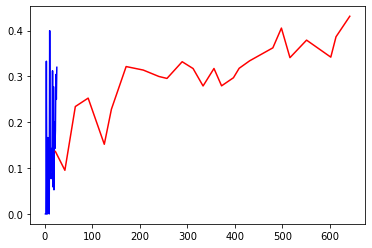

In [15]:
evaluate(import_corpus("corpus_pos.txt"))

In [ ]:
test_model = MaxEntModel()
test_model.initialize(import_corpus("corpus_pos.txt"))

In [6]:
test_model.train_batch(3, 5)
test_model.predict("Mr.", "CC")

Iteration 1/5
Iteration 2/5
Iteration 3/5
Iteration 4/5
Iteration 5/5


'IN'